In [1]:
import json 
import pandas as pd 
import numpy as np 
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
from glob import glob 
os.chdir('../')

def load_df(log_dir):
    with open(log_dir, 'r') as f: 
        data = f.readlines()
    df = pd.DataFrame(list(pd.Series(data).map(eval).values))    
    return df 

def load_log_data(class_name, version, result_dir,method):

    df = pd.DataFrame()
    for i,v in enumerate(version):
        log_dir = os.path.join(result_dir,class_name,method,v,'log.txt')
        
        temp_df = load_df(log_dir)
        temp_df['hue'] = v 
        
        df = pd.concat([df,temp_df])
    
    return df 

def plot_log(data,class_name, metrics:list, figsize:tuple = (10,7)):
    
    fig, axes = plt.subplots(len(metrics),1,figsize=figsize)
    
    for ax, metric in zip(axes, metrics):
        sns.lineplot(
            x = 'epoch',
            y = metric,
            data = data,
            hue = data['hue'],
            ax = ax 
        )
      
    fig.suptitle(class_name)
    plt.show()
    
def read_txt(log_dir):
    with open(log_dir, 'r') as f: 
        data = f.readlines()    
    df = pd.DataFrame([eval(d) for d in data]) 
    return df 

# 전체 결과 

In [2]:
version = ['*-anomaly_ratio_0.0']

result_dir = './results'
dataset = ''
method = '*'
log_dirs = glob('/Volume/ProxyCore/results/*/*/*/*-anomaly_ratio_*/seed_0/result.txt')

df = pd.DataFrame()

for log_dir in log_dirs:
    auroc_list = {}
    method = log_dir.split('/')[-6]
    dataset = log_dir.split('/')[-5]
    class_name = log_dir.split('/')[-4]
    exp_name = log_dir.split('/')[-3].split('-')[0]

    data = load_df(log_dir)

    met = [d['img_level']['auroc'] for d in data['test_metrics']]    
    if method in ['ReconPatch','ProxyCoreBase']:
        met[0] = 0
        
    idx = np.argmax(met)
    
    result = pd.DataFrame(data['test_metrics'][idx])
    result = result.reset_index().melt(['index'])
    result.columns = ['metric','level','value']
    
    if exp_name == 'baseline_yen':
        method = 'softpatch-yen'
    anomaly_ratio = float(log_dir.split('/')[-3].split('_')[-1])
    
    for c in ['method','dataset','class_name','exp_name','anomaly_ratio']:
        result[c] = eval(c) 
    
    
    
    df = pd.concat([df,result])

df = df[df['metric'].apply(lambda x : x in ['auroc','loco_auroc','average_precision'])].reset_index(drop=True)
df.loc[df['metric']=='loco_auroc','structural_anomalies'] = df[df['metric']=='loco_auroc']['value'].apply(lambda x : x['structural_anomalies'])
df.loc[df['metric']=='loco_auroc','logical_anomalies'] = df[df['metric']=='loco_auroc']['value'].apply(lambda x : x['logical_anomalies'])

# df = df.melt(['index','class','anomaly_ratio','exp_name'])
# # exp_d = {'Proxy_single_base' : 'ProxyNCA', 'Proxy_single_anchor_loss':'Proxy anchor', 'Proxy_nsoftmax' : 'Proxy nSoftmax'}
# # df['exp_name'] = df['exp_name'].map(exp_d)
# ind_d = {'img_level':'Image Level', 'pix_level' : 'Pixel Level'}
# df['index'] = df['index'].map(ind_d)

## 정량 결과  

In [9]:
#columns = ['ReverseDistillation','FastFlow','PatchCore','SoftPatch','softpatch-yen','ReconPatch','ProxyCoreBase']
columns = ['PatchCore','ProxyCoreBase']
mvtec = df[   (df['dataset'] == 'MVTecAD')&
   (df['anomaly_ratio']==0)].pivot_table(index=['class_name','metric'],columns=['method','level'],values='value')

mvtec[columns]

method                       PatchCore           ProxyCoreBase          
level                        img_level pix_level     img_level pix_level
class_name metric                                                       
bottle     auroc                   1.0  0.989503           1.0  0.988236
           average_precision       1.0  0.862275           1.0  0.841019
cable      auroc              0.958333  0.976297      0.959411  0.975627
           average_precision  0.962367  0.714678      0.956954  0.716727
capsule    auroc              0.987484  0.989108      0.992095  0.989756
           average_precision  0.995588  0.544874      0.997403  0.548732
carpet     auroc              0.971861   0.98755      0.975108  0.986836
           average_precision  0.981577  0.628497      0.985404  0.599231
grid       auroc                   1.0  0.997093           1.0  0.997357
           average_precision       1.0  0.594024           1.0  0.582047
leather    auroc                   1.0  0.994524           1.0  0.994664
           average_precision       1.0  0.528585           1.0  0.532132
metal_nut  auroc                   1.0  0.982339           1.0  0.983295
           average_precision       1.0  0.870517           1.0  0.875265
pill       auroc              0.947552  0.966861      0.949738   0.97009
           average_precision  0.984109  0.684864      0.985125  0.676932
screw      auroc              0.978271  0.994908      0.970953  0.993205
           average_precision  0.982456  0.487658      0.982313    0.4711
tile       auroc              0.979266  0.962227      0.984051  0.962135
           average_precision  0.987996  0.594434      0.990448  0.595563
toothbrush auroc                   1.0   0.98964           1.0  0.989305
           average_precision       1.0  0.595991           1.0  0.590168
wood       auroc              0.995215  0.957405           1.0  0.964849
           average_precision   0.99208  0.466606           1.0  0.465079
zipper     auroc               0.99956  0.990408      0.998239  0.989237
           average_precision  0.999803  0.683397      0.999195  0.630555

In [23]:
columns = ['ReverseDistillation','FastFlow','PatchCore','SoftPatch','softpatch-yen','ReconPatch','ProxyCoreBase']
mvtec = df[(df['metric']=='loco_auroc')&
   (df['dataset'] == 'MVTecLoco')&
   (df['level'] == 'img_level') ].pivot_table(index=['class_name'],columns=['method','anomaly_ratio'],values='structural_anomalies')

mvtec['ReconPatch']

anomaly_ratio,0.0,0.1,0.2
class_name,,,
breakfast_box,0.861592,0.833718,0.815456
juice_bottle,0.960229,0.946481,0.947954
pushpins,0.825224,0.823844,0.754486
screw_bag,0.751205,NaN,0.720186
splicing_connectors,0.858992,NaN,0.883529


In [37]:
columns = ['ReverseDistillation','FastFlow','PatchCore','SoftPatch','softpatch-yen','ReconPatch','ProxyCoreBase']
mvtec = df[(df['metric']=='loco_auroc')&
   (df['dataset'] == 'MVTecLoco')&
   (df['level'] == 'img_level') ].pivot_table(index=['class_name'],columns=['method','anomaly_ratio'],values='structural_anomalies')

mvtec[columns]

method              ReverseDistillation                      FastFlow  \
anomaly_ratio                       0.0       0.1       0.2       0.0   
class_name                                                              
breakfast_box                  0.638601  0.628797  0.629758  0.619954   
juice_bottle                   0.931751  0.920131  0.911293  0.983470   
pushpins                       0.822291  0.818668  0.817115  0.839199   
screw_bag                      0.810511  0.795725  0.774992  0.767438   
splicing_connectors            0.836639  0.875462  0.838824  0.868571   

method                                  PatchCore                      \
anomaly_ratio             0.1       0.2       0.0       0.1       0.2   
class_name                                                              
breakfast_box        0.614571  0.622837  0.751826  0.728181  0.731257   
juice_bottle         0.957447  0.980360  0.945008  0.929133  0.913748   
pushpins             0.836784  0.806073  0.802450  0.797447  0.751208   
screw_bag            0.822404  0.828994  0.843298  0.833815  0.818386   
splicing_connectors  0.814790  0.816807  0.893109  0.888908  0.886555   

method              SoftPatch  ...           softpatch-yen            \
anomaly_ratio             0.0  ...       0.2           0.0       0.1   
class_name                     ...                                     
breakfast_box        0.745290  ...  0.758554      0.729912  0.772203   
juice_bottle         0.930278  ...  0.937643      0.948936  0.950082   
pushpins             0.794341  ...  0.757074      0.797274  0.804520   
screw_bag            0.791064  ...  0.813565      0.791385  0.810511   
splicing_connectors  0.883866  ...  0.874790      0.890420  0.879160   

method                        ReconPatch                     ProxyCoreBase  \
anomaly_ratio             0.2        0.0       0.1       0.2           0.0   
class_name                                                                   
breakfast_box        0.711842   0.861592  0.833718  0.815456      0.720877   
juice_bottle         0.949755   0.960229  0.946481  0.947954      0.924714   
pushpins             0.741373   0.825224  0.823844  0.754486      0.840752   
screw_bag            0.798296   0.751205  0.752491  0.720186      0.804564   
splicing_connectors  0.877311   0.858992  0.858151  0.847395      0.896471   

method                                   
anomaly_ratio             0.1       0.2  
class_name                               
breakfast_box        0.713379  0.699154  
juice_bottle         0.900000  0.897381  
pushpins             0.793996  0.778468  
screw_bag            0.822404  0.822565  
splicing_connectors  0.893277  0.892437  

[5 rows x 21 columns]

## loco auroc 

# 시각화 

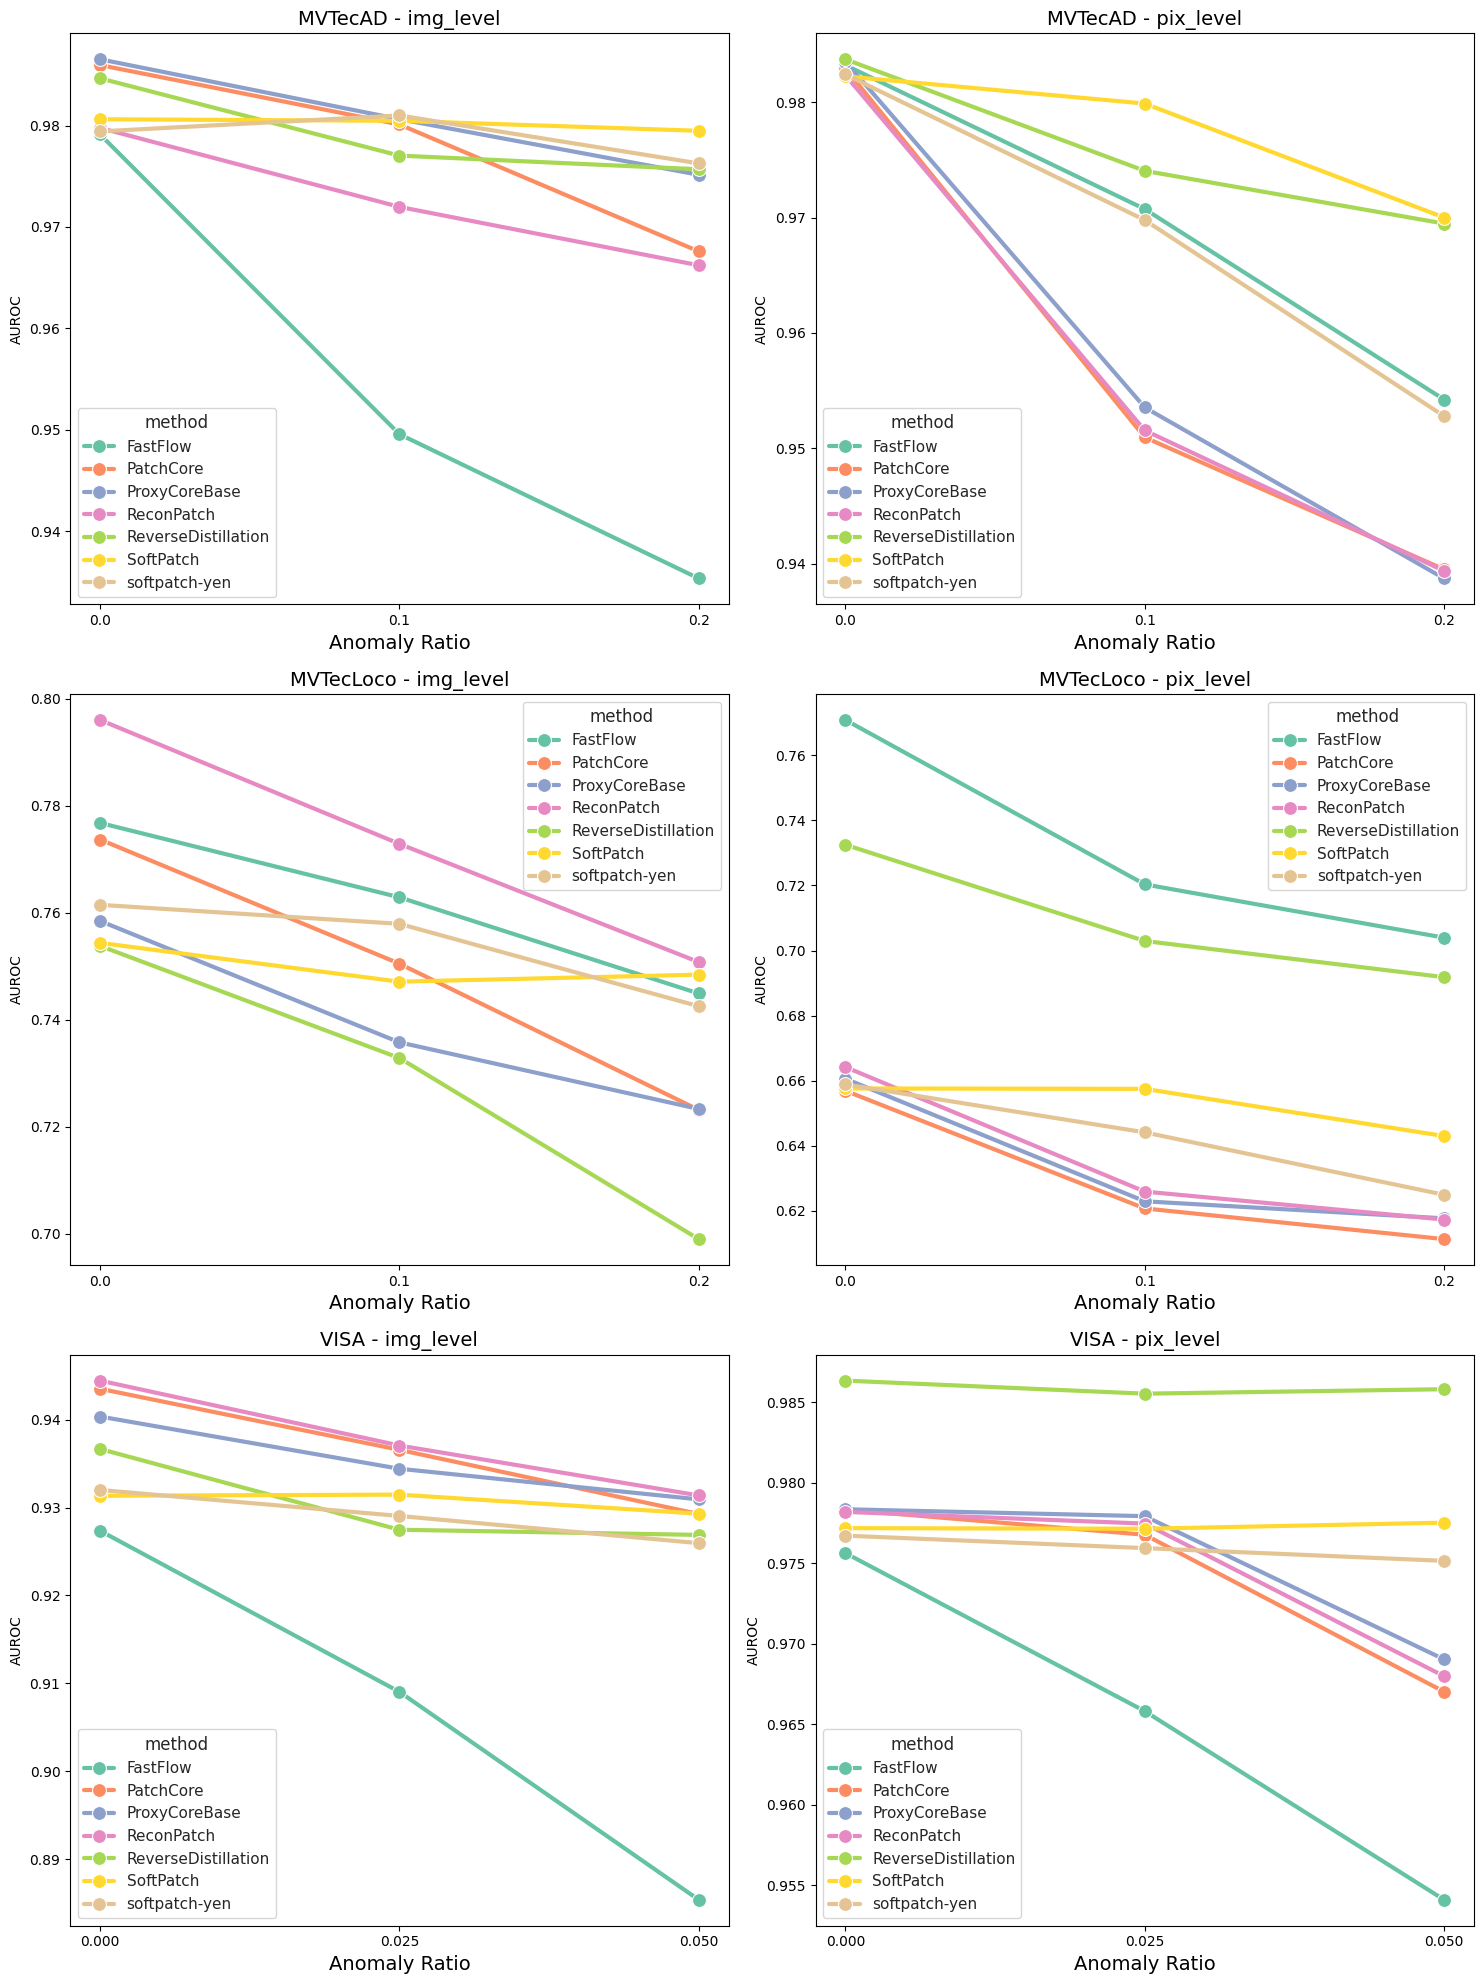

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터셋 설정
metrics = ['auroc']
levels = ['img_level', 'pix_level']
datasets = ['MVTecAD', 'MVTecLoco', 'VISA']

# 총 6개의 subplot을 생성 (2열 3행)
fig, axes = plt.subplots(3, 2, figsize=(15, 20))  # 전체 figure의 크기 조절이 필요할 수 있습니다.

for i, m in enumerate(metrics):
    for j, l in enumerate(levels):
        for k, d in enumerate(datasets):
            ax = axes[k, j]  # 현재 subplot 선택
            plot_df = df[(df['metric'] == m) &
                         (df['level'] == l) &
                         (df['dataset'] == d)]

            sns.set(style="whitegrid")  # Set the background style
            sns.lineplot(
                x='anomaly_ratio',
                y='value',
                data=plot_df.groupby(['method', 'anomaly_ratio'])['value'].mean().reset_index(),
                hue='method',
                linewidth=3,
                markers=True,
                marker='o',
                palette='Set2',
                markersize=10,
                ax=ax  # 이 줄을 추가하여 현재 subplot에 그리기
            )
            ax.set_xlabel("Anomaly Ratio", size=14)
            ax.set_ylabel(f"AUROC")
            if k !=2:
                ax.set_xticks([0,0.1,0.2])
            else:
                ax.set_xticks([0,0.025,0.05])
            ax.set_title(f'{d} - {l}',fontsize=14)  # 각 subplot에 제목 추가
            # ax.tick_params(labelsize=10)
            # ax.tick_


# subplot 간 간격 조정
plt.tight_layout()

plt.show()


In [44]:
ax.get_yaxis()

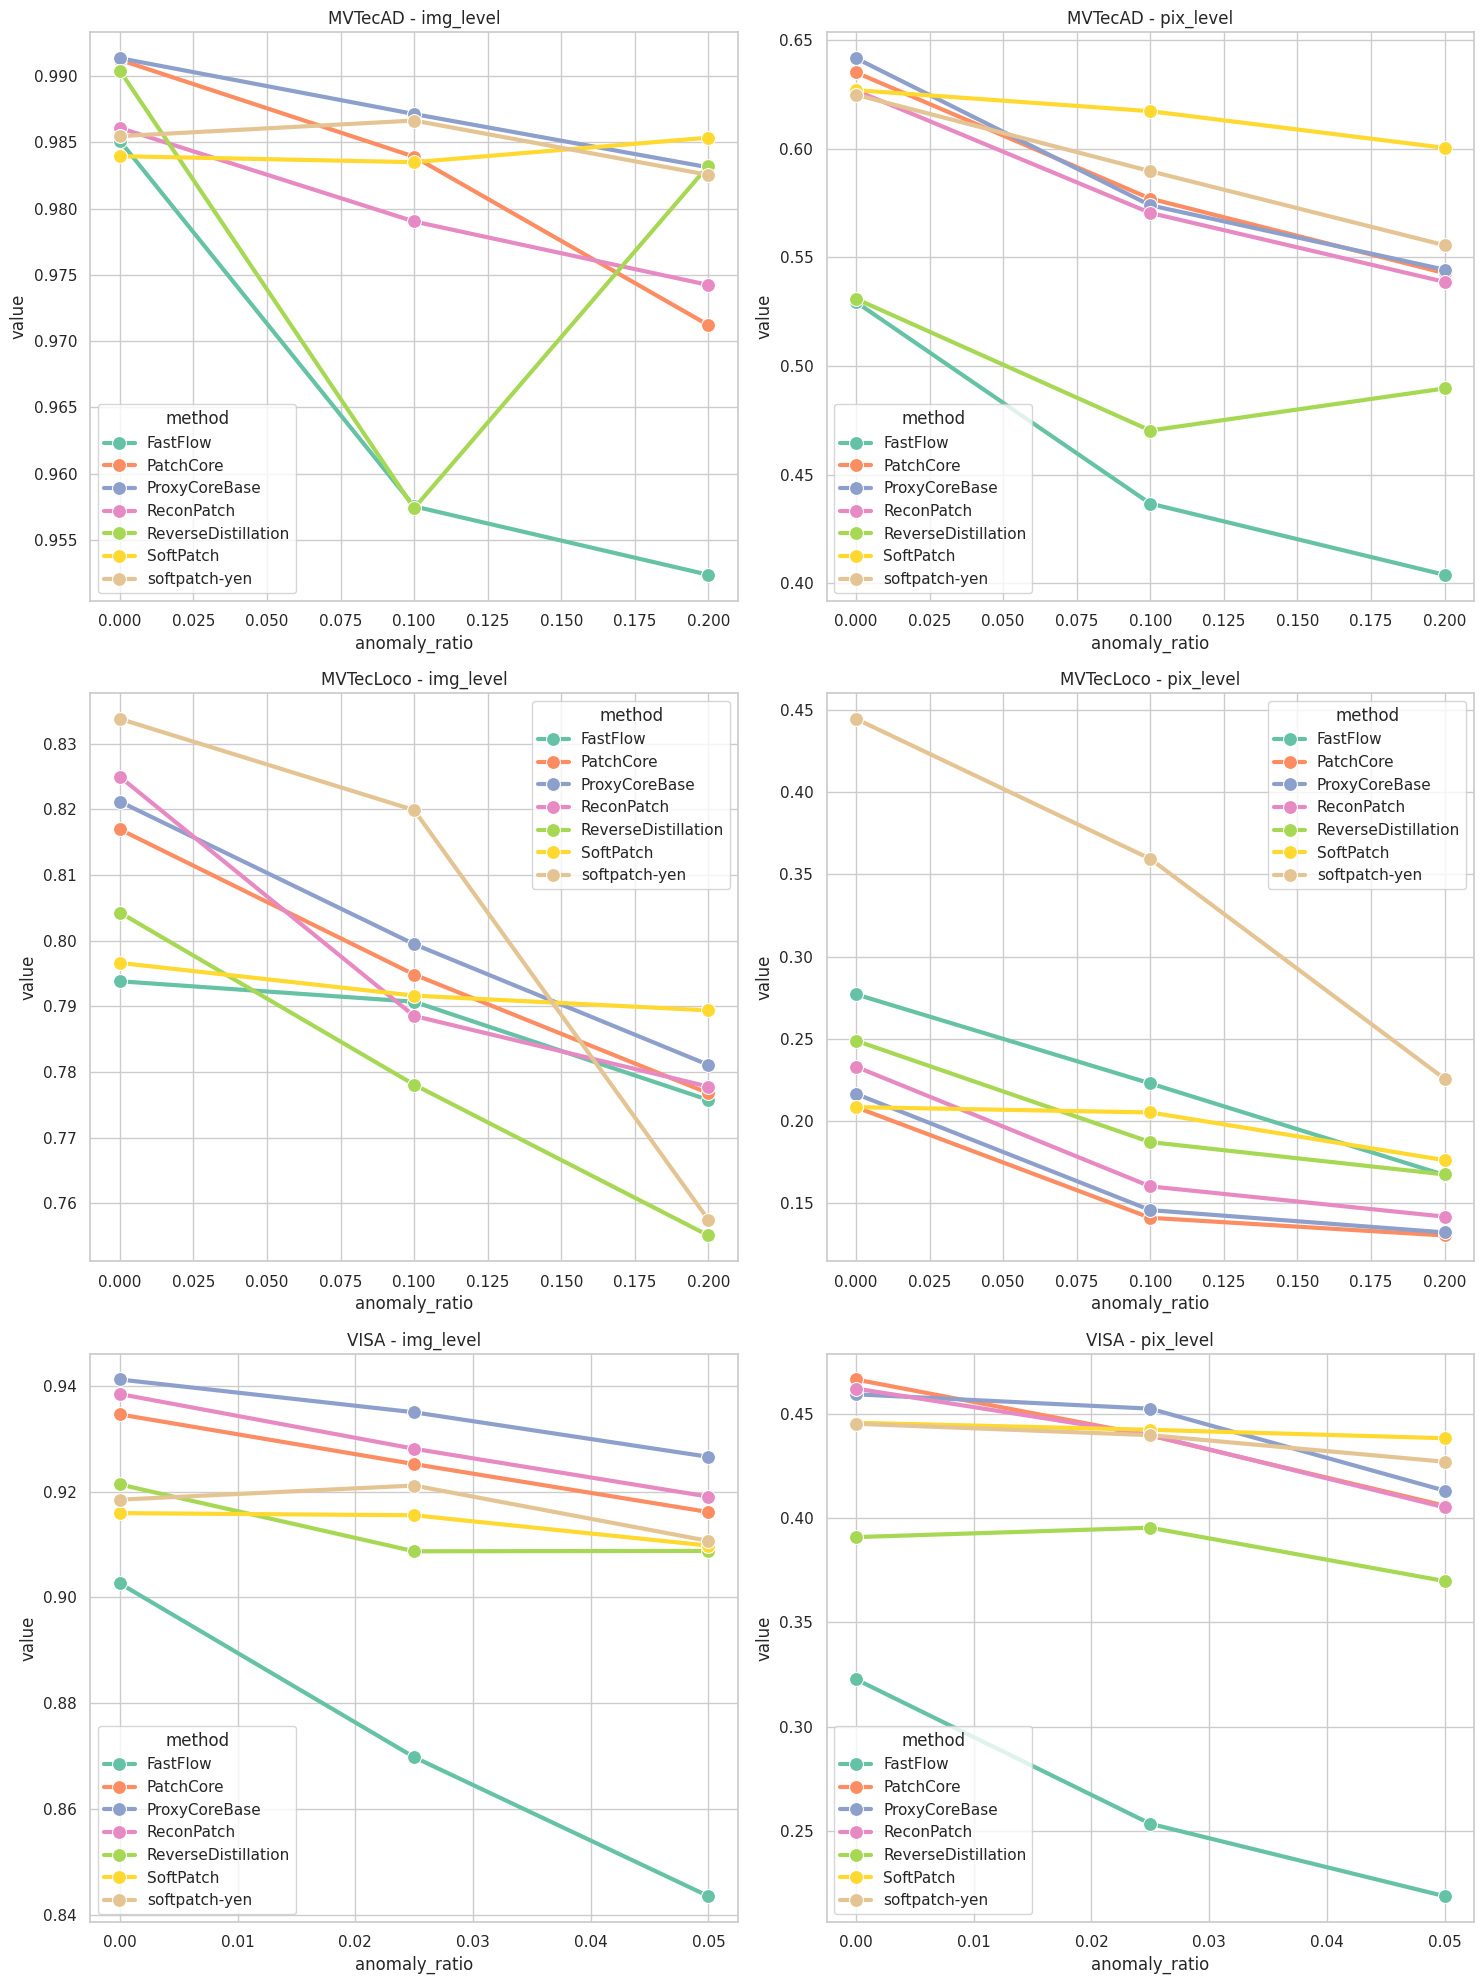

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터셋 설정
metrics = ['average_precision']
levels = ['img_level', 'pix_level']
datasets = ['MVTecAD', 'MVTecLoco', 'VISA']

# 총 6개의 subplot을 생성 (2열 3행)
fig, axes = plt.subplots(3, 2, figsize=(15, 20))  # 전체 figure의 크기 조절이 필요할 수 있습니다.

for i, m in enumerate(metrics):
    for j, l in enumerate(levels):
        for k, d in enumerate(datasets):
            ax = axes[k, j]  # 현재 subplot 선택
            plot_df = df[(df['metric'] == m) &
                         (df['level'] == l) &
                         (df['dataset'] == d)]

            sns.set(style="whitegrid")  # Set the background style
            sns.lineplot(
                x='anomaly_ratio',
                y='value',
                data=plot_df.groupby(['method', 'anomaly_ratio'])['value'].mean().reset_index(),
                hue='method',
                linewidth=3,
                markers=True,
                marker='o',
                palette='Set2',
                markersize=10,
                ax=ax  # 이 줄을 추가하여 현재 subplot에 그리기
            )
            ax.set_title(f'{d} - {l}')  # 각 subplot에 제목 추가

# subplot 간 간격 조정
plt.tight_layout()

plt.show()
